In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
import random

In [2]:
class ImageDomain:
    
    def __init__(self, filename, domain, background_threshold, remove_padding=False):
        
        self.filename = filename
        self.domain = domain
        self.background_threshold = background_threshold
        
        image = read_image(filename)[:3]
        image = T.Grayscale()(image).squeeze(0)
        image = torch.flip(image, dims=[0]).permute(1, 0)
        
        if remove_padding:
            idx = image.nonzero()
            x_min, x_max = idx[:, 0].min(), idx[:, 0].max()
            y_min, y_max = idx[:, 1].min(), idx[:, 1].max()
            image = image[x_min:x_max, y_min:y_max]
       
        self.image = image

    def show_image(self):
        image = read_image(self.filename)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
        
    def _rescale(self, value, var):
        image_range = self.image.shape[var]
        domain_range = self.domain[var][1] - self.domain[var][0]
        return self.domain[var][0] + value * domain_range/image_range

    def check_in_domain(self, point, on_boundary=False, step=None):
        x, y = point
        
        if self.image[x, y] < self.background_threshold:
            if not on_boundary:  # la condición anterior es suficiente para estar en del dominio.
                return True
            
            # Condiciones para estar en el borde:
            elif any([x == 0, x + step + 1 > self.image.shape[0],  # el punto está en un borde vertical de la imagen.
                      y == 0, y + step + 1 > self.image.shape[1]]):  # el punto está en un borde horizontal de la imagen.
                return True
            
            else:
                for (a, b) in combinations_with_replacement([-step, 0, step], 2):
                    if self.image[x+a, y+b] > self.background_threshold:  # los puntos adyacentes están fuera del dominio.
                        return True
        
        return False
    
    def get_points(self, step, on_boundary=False, requires_grad=False):
        x = torch.arange(0, self.image.shape[0], step)
        y = torch.arange(0, self.image.shape[1], step)
        
        grid_x, grid_y = torch.meshgrid(x, y, indexing='xy')
        points = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

        x_domain, y_domain = [], []

        for (x, y) in points:
            if self.check_in_domain((x, y), on_boundary=on_boundary, step=step):
                x_domain.append(self._rescale(x, 0))
                y_domain.append(self._rescale(y, 1))
        
        x_domain = torch.tensor(x_domain, requires_grad=requires_grad)
        y_domain = torch.tensor(y_domain, requires_grad=requires_grad)
        
        return {'x': x_domain, 'y': y_domain}
    
    
    def plot_domain(self, step, boundary_lines=True):
        
        inner_points = self.get_points(step)
        boundary_points = self.get_points(step, on_boundary=True)
        
        plt.plot(inner_points['x'], inner_points['y'], '*')
        plt.plot(boundary_points['x'], boundary_points['y'], '*')
        
        if boundary_lines:
            for (x, y) in ([0, 0], [0, 1]):
                plt.axvline(self.domain[x][y], linestyle='--', alpha=0.2, color='k')
                plt.axhline(self.domain[1-x][1-y], linestyle='--', alpha=0.2, color='k')
        plt.tight_layout()
        plt.show()

# NN

In [4]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 1)
        
        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
        self.apply(init_weights)
    
    def forward(self, x, y):
        input = torch.stack([x, y], axis=1)
        
        for layer in self.inner_layers:
            input = nn.Tanh()(layer(input))
        input = self.last_layer(input)
        
        return input.squeeze(1)

In [5]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

In [6]:
cos, sin, pi = torch.cos, torch.sin, torch.pi

def pde(x, y, net):
    u = net(x, y)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_y = derivative(u, y)
    u_yy = derivative(u_y, y)
    return u_xx + u_yy - 2*x*y

def boundary_condition(x, y):
    return 5 + 0*x


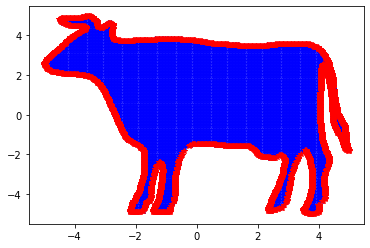

In [7]:
# Puntos para el entrenamiento:

step = 20
domain = ImageDomain('imgs/cow.jpg', [[-5, 5], [-5, 5]], 240)
#domain.plot_domain(5)

data_collocation = domain.get_points(step, requires_grad=True)
x_collocation, y_collocation = data_collocation['x'], data_collocation['y']
target_collocation = torch.zeros_like(x_collocation)

data_boundary = domain.get_points(step//4, on_boundary=True)
x_boundary, y_boundary = data_boundary['x'], data_boundary['y']
target_boundary = boundary_condition(x_boundary, y_boundary)

plt.plot(x_collocation.detach(), y_collocation.detach(), '*', color='b')
plt.plot(x_boundary.detach(), y_boundary.detach(), '*', color='r')

# Entrenamiento:
epochs = 20
loss = []

net = NeuralNetwork(n_layers=2, wide=20)
optimizer = optim.LBFGS(net.parameters())

def calc_loss():
    u_boundary = net(x_boundary, y_boundary)     
    loss_boundary = nn.MSELoss()(u_boundary, target_boundary)

    pde_collocation = pde(x_collocation, y_collocation, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
    
    return loss_collocation + loss_boundary

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

for epoch in range(1, epochs + 1):
    optimizer.step(closure)
    loss.append(calc_loss().item())
    

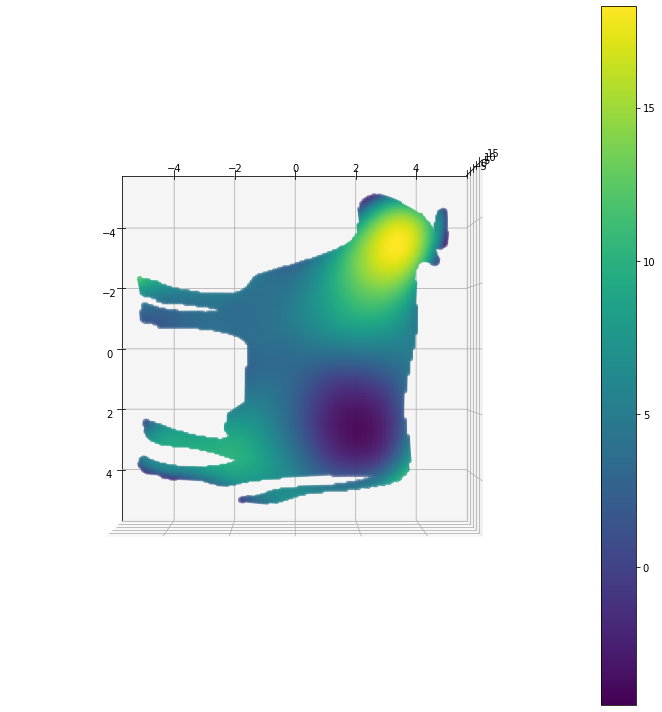

In [11]:
step_test = 10
data = domain.get_points(step_test)
x, y = data['x'], data['y']

net.eval()
u_pred = net(x, y).detach()

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

simulation = ax.scatter(x, y, u_pred, c=u_pred)
plt.colorbar(simulation)
ax.view_init(elev=90, azim=0)
plt.tight_layout()
plt.show()